In [1]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.append("../../")

import numpy as np
from matplotlib import pyplot as plt

from lava.proc.io.source import RingBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer

from lava.magma.core.run_configs import RunConfig, Loihi1SimCfg
from lava.magma.core.run_conditions import RunSteps

from semd.proc.semd.process import SemdLayer

from utils import get_events_range

In [2]:
events = np.loadtxt("../../data_processed/events_refact.txt")
# this data is already filtered by time, no need to redo it here

In [3]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [4]:
def gen_input_data(events, shape, timesteps):
    result = np.zeros((shape[0], shape[1], timesteps), dtype=int)
    for e in events:
        x = int(e[1])
        y = int(e[2])

        time = int((float(e[0]) - t_start) / duration * timesteps) - 1

        if e[3] == 1:
            continue

        result[y, x, time] = 1
    return result

In [5]:
def run_sim(args, events):
    shape = args["shape"]
    conv_stride = args["conv_stride"]
    conv_shape = args["conv_shape"]
    
#     out_shape = (int(shape[0] / conv_stride[0]), int(shape[1] / conv_stride[1]))
#     detector_shape = (out_shape[0], out_shape[1] - 1)
    
    semd = SemdLayer(**args)
    
    out_shape = semd.out_shape
    detector_shape = semd.detector_shape

    input_data = gen_input_data(events, shape, timesteps)
    input_n = RingBuffer(input_data)

    output_n = SinkBuffer(shape=detector_shape, buffer=steps)

    input_n.s_out.connect(semd.s_in)
    semd.s_out.connect(output_n.a_in)

    rcfg = Loihi1SimCfg(select_tag='floating_pt', select_sub_proc_model=True)

    for i in range(steps):
        run_condition = RunSteps(num_steps=1)
        input_n.run(condition=run_condition, run_cfg=rcfg)
    data = output_n.data.get()
    input_n.stop()
    
    return data

In [6]:
# use only the specified patch of input events
patch_center = (90, 120)
patch_size = 180
events = filter_patch(events, patch_center, patch_size)

timesteps = 100 # timesteps to divide the data into
steps = 100 # simulation steps
shape = (patch_size, patch_size)
t_start = events[0, 0]
duration = events[-1, 0] - events[0, 0]

0.65
10
(3, 3)
0.65
[[[[1.70940171]
   [1.70940171]
   [1.70940171]]

  [[1.70940171]
   [1.70940171]
   [1.70940171]]

  [[1.70940171]
   [1.70940171]
   [1.70940171]]]]
1.7094017094017093


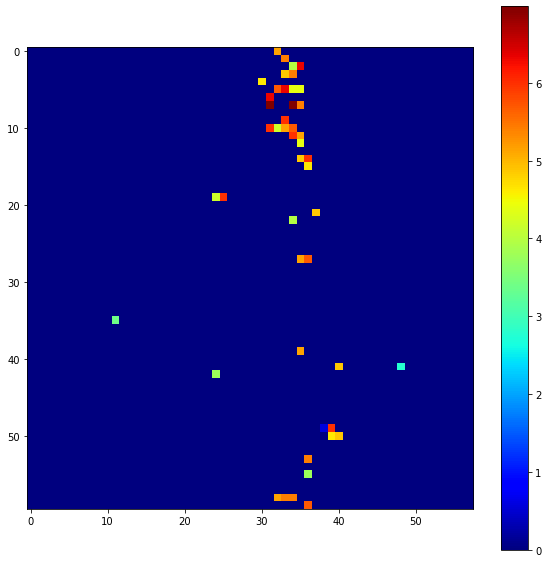

In [7]:
args = {
    "shape":shape,
    "conv_shape": (3,3),
    "conv_stride": (3,3),
    "thresh_conv": 0.65
}
data = run_sim(args, events)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

0.5
10
(2, 2)
0.5
[[[[5.]
   [5.]]

  [[5.]
   [5.]]]]
5.0


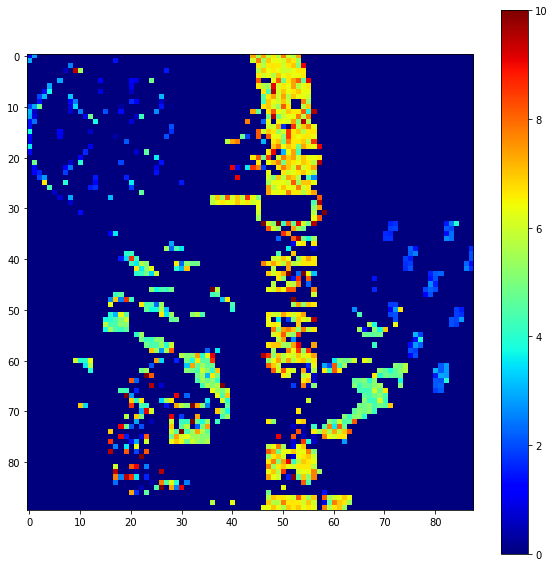

In [8]:
args = {
    "shape":shape,
    "conv_shape": (2,2),
    "conv_stride": (2,2),
    "thresh_conv": 0.5
}
data = run_sim(args, events)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

0.5
10
(4, 4)
0.5
[[[[1.25]
   [1.25]
   [1.25]
   [1.25]]

  [[1.25]
   [1.25]
   [1.25]
   [1.25]]

  [[1.25]
   [1.25]
   [1.25]
   [1.25]]

  [[1.25]
   [1.25]
   [1.25]
   [1.25]]]]
1.25


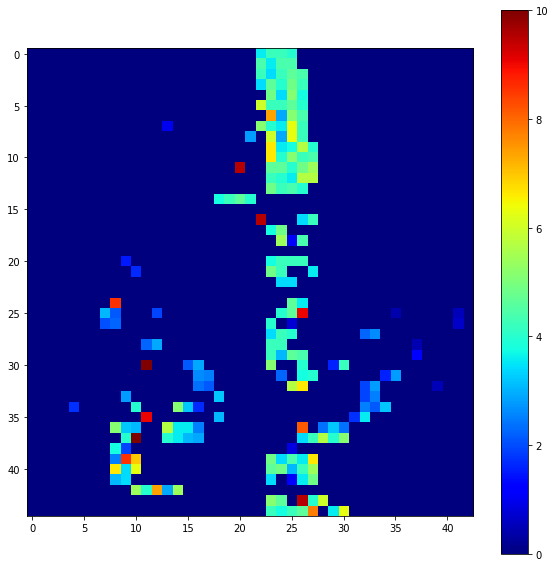

In [9]:
args = {
    "shape":shape,
    "conv_shape": (4,4),
    "conv_stride": (4,4),
    "thresh_conv": 0.5
}
data = run_sim(args, events)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

0.6
10
(5, 5)
0.6
[[[[0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]]

  [[0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]]

  [[0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]]

  [[0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]]

  [[0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]
   [0.66666667]]]]
0.6666666666666667


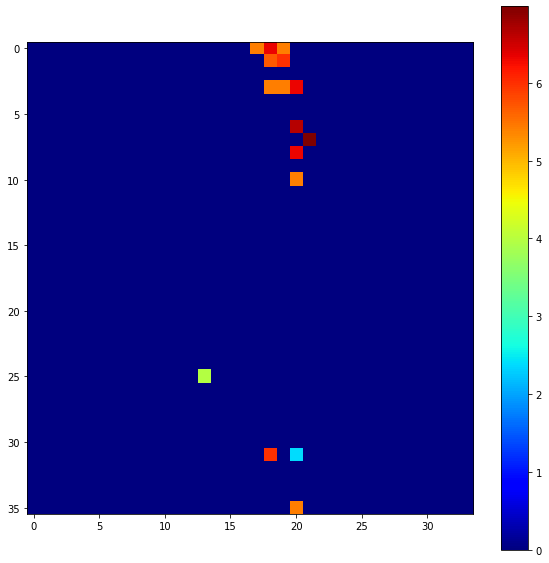

In [16]:
args = {
    "shape":shape,
    "conv_shape": (5,5),
    "conv_stride": (5,5),
    "thresh_conv": 0.6
}
data = run_sim(args, events)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

In [22]:
args = {
    "shape":shape,
    "conv_shape": (2,2),
    "conv_stride": (1,1),
    "thresh_conv": 0.5
}
data = run_sim(args, events)

0.5
10
(2, 2)
0.5
[[[[5.]
   [5.]]

  [[5.]
   [5.]]]]
5.0


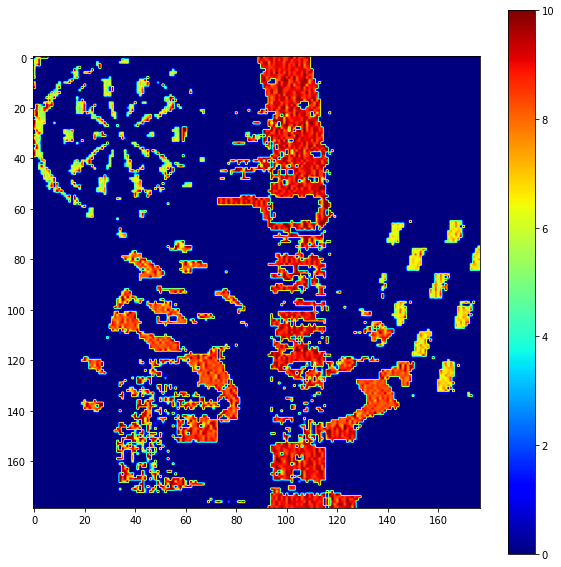

In [23]:
plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

In [25]:
args = {
    "shape":shape,
    "conv_shape": (1,1),
    "conv_stride": (1,1),
    "thresh_conv": 1
}
data = run_sim(args, events)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data, axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

NoProcessModelFound: No ProcessModels found that implement Process '<semd.proc.semd.process.SemdLayer object at 0x0000018025F18CA0>'

0.5
10
(2, 2)
0.5
[[[[5.]
   [5.]]

  [[5.]
   [5.]]]]
5.0


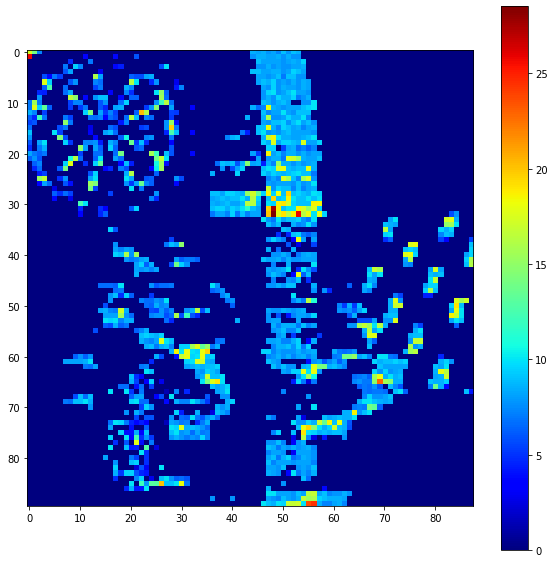

In [13]:
events_unfiltered = np.loadtxt("../../data/events.txt")
t_start = 2.6
duration = 0.1
events_unfiltered = get_events_range(events_unfiltered, t_start, duration)

# use only the specified patch of input events
patch_center = (90, 120)
patch_size = 180
events_unfiltered = filter_patch(events_unfiltered, patch_center, patch_size)

timesteps = 50 # timesteps to divide the data into
steps = 50 # simulation steps
shape = (patch_size, patch_size)

args = {
    "shape":shape,
    "conv_shape": (2,2),
    "conv_stride": (2,2),
    "thresh_conv": 0.5
}
data = run_sim(args, events_unfiltered)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data[:,:,:], axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

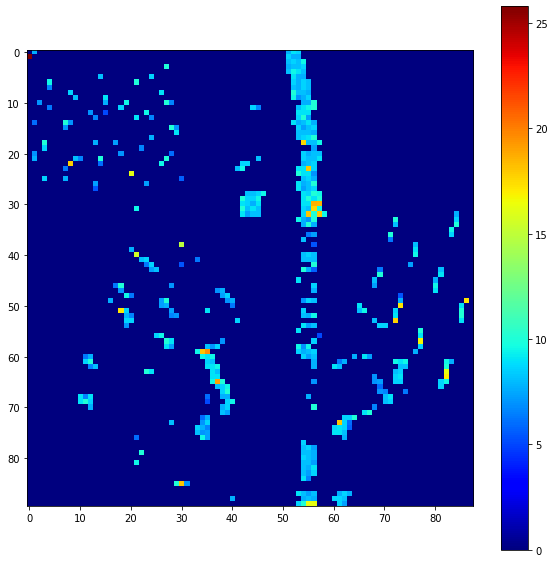

In [14]:
plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data[:,:,:20], axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)

0.5
10
(2, 2)
0.5
[[[[5.]
   [5.]]

  [[5.]
   [5.]]]]
5.0


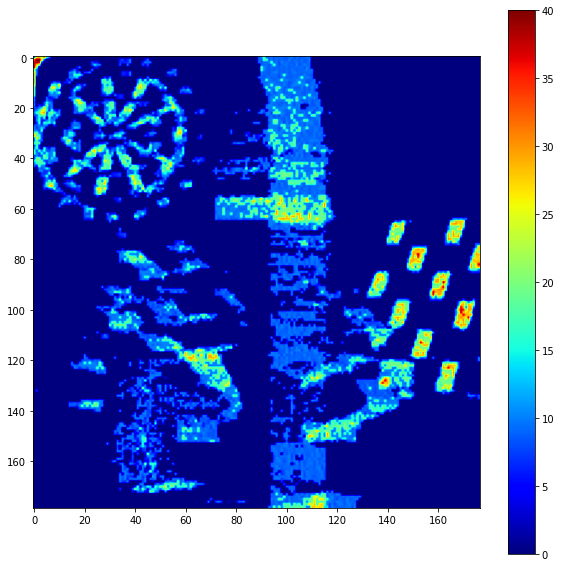

In [15]:
args = {
    "shape":shape,
    "conv_shape": (2,2),
    "conv_stride": (1,1),
    "thresh_conv": 0.5
}
data = run_sim(args, events_unfiltered)

plt.figure(figsize=(10, 10))
m = plt.imshow(np.delete(np.sum(data[:,:,:], axis=-1), 0, 1), cmap="jet")
plt.colorbar(m)